In this notebook I am going to do some EDA and preprocessing using @ivser notebook (thanks for sharing)

Задача 1. Прогнозирование
Основная цель этого блока реализовать систему прогнозирования спроса на краткосрочный период (14 дней) через 7 дней с момента начала прогноза, для всех групп товаров. Стремимся, что вы ваша система была точнее и быстрее нашей текущей реализации. Важно учесть, что бы система могла выдать примерных прогноз для товаров-новичков.
На выходе: операционализированное решение с интерфейсом для загрузки данных и выгрузки результатов.

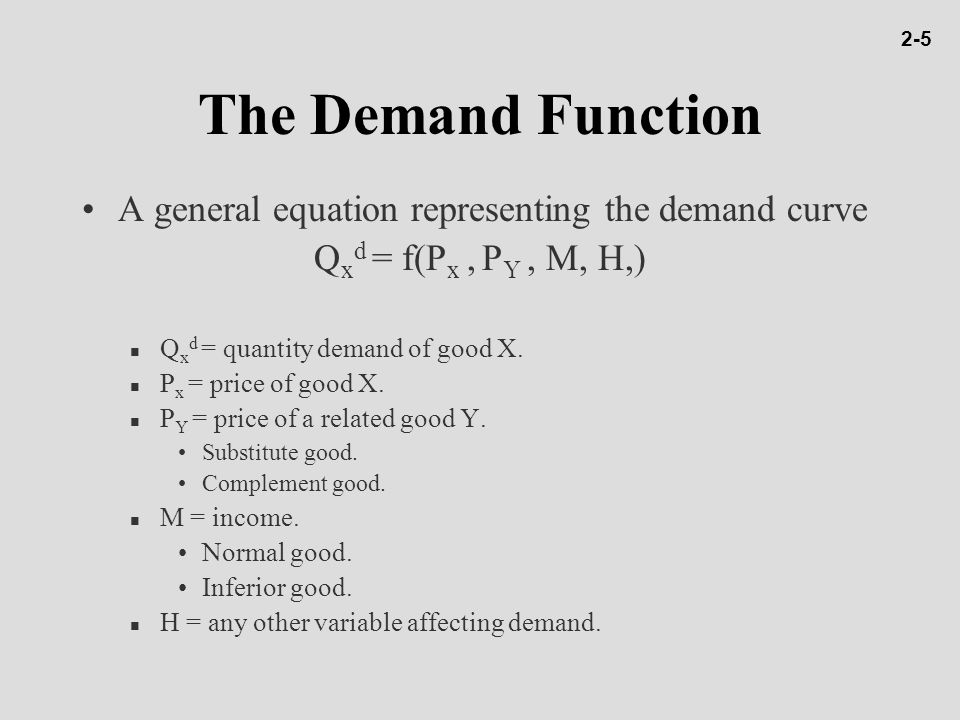

In [1]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Colab Notebooks/Smart_academy/TS/The_Demand_Function.jpeg')

#Data Load & Cleaning

In [2]:
#pip install pandas==0.25

In [3]:
#Importing packages

import pandas as pd, datetime
import pandas_profiling as pp
import numpy as np
import pandas as pd

from scipy import stats
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

##Products


*   product_id - unique product identifier
*   product_category_name - root category of product
*   product_name_lenght - number of characters extracted from the product name
*   product_description_lenght - number of characters extracted from the product description.
*   product_photos_qty - number of product published photos
*   product_weight_g - product weight measured in grams
*   product_length_cm - product length measured in centimeters
*   product_height_cm - product height measured in centimeters.
*   product_width_cm - product width measured in centimeters


In [4]:
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smart_academy/TS/data/products.csv')

print(products.shape)
products.head()

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [5]:
#pp.ProfileReport(products)

## Order_items

*   order_id - order unique identifier
*   order_item_id - sequential number identifying number of items included in the same order
*   product_id - product unique identifier
*   seller_id - seller unique identifier
*   shipping_limit_date - Shows the seller shipping limit date for handling the order over to the logistic partner
*   price - item price
*   freight_value;item freight value item (if an order has more than one item the freight value is splitted between items)










In [6]:
order_items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smart_academy/TS/data/order_items.csv', parse_dates=[4])
print(order_items.shape)
order_items.head()

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
#pp.ProfileReport(order_items)

In [8]:
order_items['order_item_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

## Orders

*   order_id - unique identifier of the order.
*   customer_id - key to the customer dataset. Each order has a unique customer_id
*   order_status - Reference to the order status (delivered
*   order_purchase_timestamp - Shows the purchase timestamp
*   order_approved_at - Shows the payment approval timestamp
*   order_delivered_carrier_date - Shows the order posting timestamp. When it was handled to the logistic partner
*   order_delivered_customer_date - Shows the actual order delivery date to the customer
*   order_estimated_delivery_date - Shows the estimated delivery date that was informed to customer at the purchase moment



In [9]:
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Smart_academy/TS/data/orders.csv', parse_dates=['order_approved_at'])
print(orders.shape)
orders.head()

(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
orders['order_approved_at'].isna().sum()

160

In [11]:
#lets check null values

orders[orders['order_approved_at'].isnull()].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaN,NaN,2018-09-12 00:00:00
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaN,NaN,2018-10-17 00:00:00
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaN,NaN,2017-04-10 00:00:00
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaN,NaN,2018-09-13 00:00:00
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaN,NaN,2017-05-30 00:00:00


In [12]:
#So it looks like we have some orders that have been canceled, which is normal
orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

We don't want to include orders which were canceled, because our products were not actually sold! 

In [13]:
full_data = pd.merge(orders.loc[:, ['order_id', 'order_status', 'order_approved_at']], order_items, on='order_id', how='left')

print(full_data.shape)
full_data.head()

(113425, 9)


,order_id,order_status,order_approved_at,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 11:07:15,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-26 03:24:27,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:55:23,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:45:59,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 22:20:29,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [14]:
full_data['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [15]:
#lets see how mny orders were canceled
len(full_data[full_data['order_status'] == 'canceled'])

706

In [16]:
full_data = pd.merge(products, full_data, on='product_id', how='left')
full_data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_status,order_approved_at,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,e17e4f88e31525f7deef66779844ddce,delivered,2018-04-24 19:04:19,1.0,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,5236307716393b7114b53ee991f36956,delivered,2018-01-31 19:11:15,1.0,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,01f66e58769f84129811d43eefd187fb,delivered,2018-07-09 21:30:20,1.0,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,143d00a4f2dde4e0364ee1821577adb3,delivered,2018-08-03 09:31:42,1.0,c510bc1718f0f2961eaa42a23330681a,2018-08-07 09:10:13,112.30,9.54
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,86cafb8794cb99a9b1b77fc8e48fbbbb,delivered,2018-04-11 01:30:23,1.0,0be8ff43f22e456b4e0371b2245e4d01,2018-04-17 01:30:23,37.90,8.29


In [17]:
full_data['order_approved_at'].isna().sum()

15

In [18]:
full_data.shape

(112650, 17)

In [19]:
full_data = full_data[full_data['order_status'] == 'delivered']
#and lets check
print(full_data.shape)
full_data[full_data['order_status'] == 'canceled']

(110197, 17)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_status,order_approved_at,order_item_id,seller_id,shipping_limit_date,price,freight_value


In [20]:
orders['order_approved_at'].dtype

dtype('<M8[ns]')

In [21]:
orders['order_approved_at']

0       2017-10-02 11:07:15
1       2018-07-26 03:24:27
2       2018-08-08 08:55:23
3       2017-11-18 19:45:59
4       2018-02-13 22:20:29
                ...        
99436   2017-03-09 09:54:05
99437   2018-02-06 13:10:37
99438   2017-08-27 15:04:16
99439   2018-01-08 21:36:21
99440   2018-03-09 11:20:28
Name: order_approved_at, Length: 99441, dtype: datetime64[ns]

In [22]:
full_data.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_id,order_status,order_approved_at,order_item_id,seller_id,shipping_limit_date,price,freight_value
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,e17e4f88e31525f7deef66779844ddce,delivered,2018-04-24 19:04:19,1.0,5670f4db5b62c43d542e1b2d56b0cf7c,2018-04-30 17:33:54,10.91,7.39
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,5236307716393b7114b53ee991f36956,delivered,2018-01-31 19:11:15,1.0,b561927807645834b59ef0d16ba55a24,2018-02-06 19:11:15,248.00,17.99
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,01f66e58769f84129811d43eefd187fb,delivered,2018-07-09 21:30:20,1.0,7b07b3c7487f0ea825fc6df75abd658b,2018-07-11 21:30:20,79.80,7.82


In [23]:
#lets check how many categories we have

print(len(products['product_category_name'].unique()))
products['product_category_name'].unique()

74


array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', nan,
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
   

In [24]:
#amount of products for dif category
cat = products.groupby(['product_category_name'])['product_id'].count()

pd.DataFrame(cat.sort_values(ascending=False))

,product_id
product_category_name,
cama_mesa_banho,3029
esporte_lazer,2867
moveis_decoracao,2657
beleza_saude,2444
utilidades_domesticas,2335
automotivo,1900
informatica_acessorios,1639
brinquedos,1411
relogios_presentes,1329


In [25]:
#lets seletect less features for now...
features = ['order_approved_at', 'product_id', 'product_category_name', 'price']

In [26]:
full_data[features].head(3)

,order_approved_at,product_id,product_category_name,price
0,2018-04-24 19:04:19,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,10.91
1,2018-01-31 19:11:15,3aa071139cb16b67ca9e5dea641aaa2f,artes,248.00
2,2018-07-09 21:30:20,96bd76ec8810374ed1b65e291975717f,esporte_lazer,79.80


In [27]:
full_data = full_data[features].sort_values(by=['order_approved_at'])
full_data.head()

,order_approved_at,product_id,product_category_name,price
33598,2016-09-15 12:16:38,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99
33599,2016-09-15 12:16:38,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99
33597,2016-09-15 12:16:38,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99
108727,2016-10-04 09:43:32,33430c5c1027d812b5c62f778e5ee7f7,consoles_games,32.49
25446,2016-10-04 10:19:23,e2a1d45a73dc7f5a7f9236b043431b89,fashion_calcados,29.99


In [28]:
full_data.set_index('order_approved_at', inplace = True)

In [29]:
#downsampling and calulate sales quantity

